# <center>TP BANDITS</center>

L'objet de ce TP sera de comparer 3 algorithmes sur les bandits.

<b>Errata :</b><br>
<u>page 2</u> : dans l'approche gloutonne, remplacer I_t par I_s (on parle de state et pas de nombre max d'actions qu'on se fixe = l'horizon ### )<br>
<u>page 3</u> : dans le théorème 1, ajouter "bornées dans [0,1]".


### Question 1/
##### Retourner la valeur du coefficient de la borne inférieure de Lai et Robbins dans computeLowerBound du fichier source.py

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 29 15:55:02 2016

TP Bandits Manchots

changer from source_correction import *
pour avoir les fonctions qui marchent correctement.

@author: claire
"""

import numpy as np
import matplotlib.pyplot as plt
from source import eGreedy, UCB, Thompson, computeLowerBound
from random import random

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'black']
graphic = True

horizon = 2000
time = np.arange(horizon)

# True parameters of the problem
true_means = np.array([0.1, 0.05, 0.02, 0.01])
n_arms = np.size(true_means)

# Nb of Monte Carlo repetitions to perform in order to compute average regret
nMC = 20

In [2]:
#### QUESTION 1 ####

# Compute the Lower Bound (lai & Robbins) :
LB = computeLowerBound(n_arms, true_means)
logLB = LB * np.log(time + 1)

print('LB >> ', LB)
print('\n')
print('logLB >>', logLB)



LB >>  5.81505804373


logLB >> [  0.           4.03069109   6.38849423 ...,  44.19387102  44.19678073
  44.19968899]


### Question 2/
##### - L’approche à l’aveugle -

In [3]:
#### QUESTION 2 ####

# No strategy : linear regret
# le Mu_1 est la plus grande des moyennes du début ( ici : np.max(true_means) ).
coeff = np.max(true_means)-np.mean(true_means)
linUB = coeff * time

print('regret moyen avec une loi uniforme de tir:', coeff)
# Voici avec un nombre d'essai "time[i]" le gain attendu dans le cas où on tire aléatoirement, sans apprendre de nos erreurs
print('gain :', linUB)

regret moyen avec une loi uniforme de tir: 0.055
gain : [  0.00000000e+00   5.50000000e-02   1.10000000e-01 ...,   1.09835000e+02
   1.09890000e+02   1.09945000e+02]


## Question 3/ & 4/
##### - L’approche gloutonne : -greedy -

<b>Compromis exploration-exploitation</b>
<ul>
<li><u>Epsilon grand</u>: l'algorithme explore beaucoup, donc trouve vite les bons
bras, mais une fois que les bons bras sont trouves, il perd des
recompenses en continuant a explorer</li>

<li><u>Epsilon petit</u>: l'algorithme exploite beaucoup, donc met du temps a
trouver les bons bras, mais une fois que ces bras sont trouves, il perd
moins en continuant d'explorer</li>
</ul>

Epsilon Greedy strategy with epsilon 0.1
Epsilon Greedy strategy with epsilon 0.5
Epsilon Greedy strategy with epsilon 0.8
Epsilon Greedy strategy with epsilon 0.9999


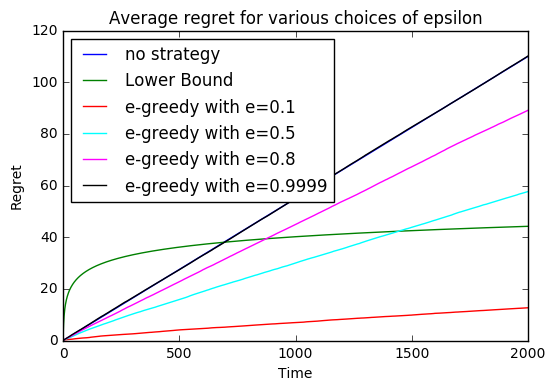

In [4]:
#  Epsilon-Greedy Approach

epsilon = np.array([0.1, 0.5, 0.8, 0.9999])  # controls EpsilonGreedy policy

# cumRegret stores the cumulated regret for each strategy
cumRegret = np.zeros((np.size(epsilon), horizon))
i = 0
for eps in epsilon:
    print('Epsilon Greedy strategy with epsilon ' + str(eps))

    for exp in np.arange(nMC):
        # Initialize statistics
        draws = np.zeros(n_arms)
        rewards = np.zeros(n_arms)
        regret = np.zeros(horizon)

        for t in time:
            arm_chosen = eGreedy(n_arms, eps, rewards, draws)
            # arm_chosen = UCB(t, rewards, draws)
            # arm_chosen = Thompson(n_arms, rewards, draws)

            draws[arm_chosen] += 1
            reward = float(random() < true_means[arm_chosen])
            rewards[arm_chosen] += reward
            regret[t] = np.max(true_means) - true_means[arm_chosen]  # exp. regret
        cumRegret[i, :] += np.cumsum(regret)
    i += 1
avgRegret = cumRegret / nMC

if graphic:
    plt.figure()
    plt.plot(linUB, color=colors[0], label='no strategy')
    plt.plot(logLB, color=colors[1], label='Lower Bound')
    for i in np.arange(np.size(epsilon)):
        plt.plot(avgRegret[i, :], color=colors[i + 2],
                 label='e-greedy with e=' + str(epsilon[i]))
    plt.xlabel('Time')
    plt.ylabel('Regret')
    plt.legend(loc=0)
    plt.title('Average regret for various choices of epsilon')
    plt.show()


Attention ici les valeurs dépendent du Monte Carlo. La courbe verte sera bien inférieures aux autres asymptotiquement, i.e. lorsque "time" (ou T) tend vers l'infini..

## Question 6/
##### - Implémenter l’optimisme : Upper Confidence Bounds (UCB) -

Les pessimistes prennent la borne inférieure la plus haute, les optimistes prennent la borne supérieure la plus haute.
<br><br>
<i>D'après l'<u>inégalité d'Hoeffing</u> :</i><br>
Plus delta est grand, plus l'intervalle de confiance (en log(1/delta)) sera petit.<br>
De plus, plus delta est grand, plus la probabilité qu'on sorte de l'intervalle de confiance sera forte.

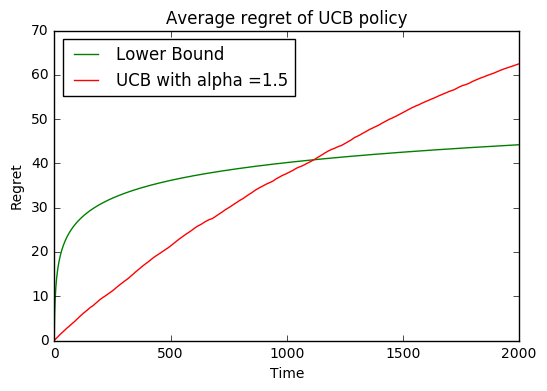

In [5]:
# Upper Confidence Bounds Approach :

# choice of alpha
alpha = 1.5

# cumRegret strores the cumulated regret for each strategy
cumRegret = np.zeros(horizon)

for exp in np.arange(nMC):
    # Initialize statistics
    draws = np.zeros(n_arms)
    rewards = np.zeros(n_arms)
    regret = np.zeros(horizon)

    for t in time:
        arm_chosen = UCB(t, alpha, rewards, draws)
        # arm_chosen = Thompson(n_arms, rewards, draws)

        draws[arm_chosen] += 1
        reward = float(random() < true_means[arm_chosen])
        rewards[arm_chosen] += reward
        regret[t] = np.max(true_means) - true_means[arm_chosen]  # exp. regret
    cumRegret += np.cumsum(regret)

avgRegret = cumRegret / nMC

if graphic:
    plt.figure()
    # plt.plot(linUB, color=colors[0], label='no strategy')
    plt.plot(logLB, color=colors[1], label='Lower Bound')
    plt.plot(avgRegret, color=colors[2], label='UCB with alpha =' + str(alpha))
    plt.xlabel('Time')
    plt.ylabel('Regret')
    plt.legend(loc=0)
    plt.title('Average regret of UCB policy')
    plt.show()



## Question 7/
##### - Exploiter l’aléa à travers une approche bayésienne : le Thompson Sampling -

<i>NB</i> :
<ul>
<li>Erratum : Remplacer q par theta</li>
<li>les paramètres alpha et beta dépendent du bras</li>
</ul>

In [ ]:
# Thompson Sampling Approach :

# cumRegret stores the cumulated regret for each strategy
cumRegret = np.zeros(horizon)

for exp in np.arange(nMC):
    # Initialize statistics
    draws = np.zeros(n_arms)
    rewards = np.zeros(n_arms)
    regret = np.zeros(horizon)

    for t in time:
        arm_chosen = Thompson(n_arms, rewards, draws)

        draws[arm_chosen] += 1
        reward = float(random() < true_means[arm_chosen])
        rewards[arm_chosen] += reward
        regret[t] = np.max(true_means) - true_means[arm_chosen]  # exp. regret
    cumRegret += np.cumsum(regret)

avgRegret = cumRegret / nMC

if graphic:
    plt.figure()
    # plt.plot(linUB, color=colors[0], label='no strategy')
    plt.plot(logLB, color=colors[1], label='Lower Bound')
    plt.plot(avgRegret, color=colors[2], label='Thompson Sampling')
    plt.xlabel('Time')
    plt.ylabel('Regret')
    plt.legend(loc=0)
    plt.title('Average regret of Thompson Sampling policy')
    plt.show()


# Comparing policies
    # TODO
